<a href="https://colab.research.google.com/github/mkmritunjay/machineLearning/blob/master/RFRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random Forest

Random Forests is a **slight variation of bagged trees** that has even better performance:

- Exactly like bagging, we create an ensemble of decision trees using bootstrapped samples of the training set.
- However, when building each tree, each time a split is considered, a **random sample of m features** is chosen as split candidates from the **full set of p features**. The split is only allowed to use **one of those m features**.
    - A new random sample of features is chosen for **every single tree at every single split**.
    - For **classification**, m is typically chosen to be the square root of p.
    - For **regression**, m is typically chosen to be somewhere between p/3 and p.

What's the point?

- Suppose there is **one very strong feature** in the data set. When using bagged trees, most of the trees will use that feature as the top split, resulting in an ensemble of similar trees that are **highly correlated**.
- Averaging highly correlated quantities does not significantly reduce variance (which is the entire goal of bagging).
- By randomly leaving out candidate features from each split, **Random Forests "decorrelates" the trees**, such that the averaging process can reduce the variance of the resulting model.

---
### Tuning n_estimators

One important tuning parameter is **n_estimators**, which is the number of trees that should be grown. It should be a large enough value that the error seems to have "stabilized".

---
### Tuning max_features

The other important tuning parameter is **max_features**, which is the number of features that should be considered at each split.

---
## Comparing Random Forests with decision trees

**Advantages of Random Forests:**

- Performance is competitive with the best supervised learning methods
- Provides a more reliable estimate of feature importance
- Allows you to estimate out-of-sample error without using train/test split or cross-validation

**Disadvantages of Random Forests:**

- Less interpretable
- Slower to train
- Slower to predict

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as sm
import scipy.stats as stats

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True
plt.gray()

from matplotlib.backends.backend_pdf import PdfPages

from sklearn.model_selection import train_test_split
from sklearn import metrics

from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from sklearn.metrics import mean_absolute_error, mean_squared_error

import sklearn.tree as dt
import sklearn.ensemble as en

from sklearn import metrics
from sklearn.tree import export_graphviz, export
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

import pydotplus as pdot
from IPython.display import Image

url = 'https://raw.githubusercontent.com/mkmritunjay/machineLearning/master/Car_sales.csv'

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.tree.export module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


<Figure size 720x540 with 0 Axes>

In [2]:
car_sales = pd.read_csv(url)
car_sales.head()

,Manufacturer,Model,Sales_in_thousands,four_year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
0,Acura,Integra,16.919,16.360,Passenger,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2/2/2012,58.280150
1,Acura,TL,39.384,19.875,Passenger,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,6/3/2011,91.370778
2,Acura,CL,14.114,18.225,Passenger,NaN,3.2,225.0,106.9,70.6,192.0,3.470,17.2,26.0,1/4/2012,NaN
3,Acura,RL,8.588,29.725,Passenger,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,3/10/2011,91.389779
4,Audi,A4,20.397,22.255,Passenger,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,10/8/2011,62.777639


In [3]:
car_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 16 columns):
Manufacturer              157 non-null object
Model                     157 non-null object
Sales_in_thousands        157 non-null float64
four_year_resale_value    121 non-null float64
Vehicle_type              157 non-null object
Price_in_thousands        155 non-null float64
Engine_size               156 non-null float64
Horsepower                156 non-null float64
Wheelbase                 156 non-null float64
Width                     156 non-null float64
Length                    156 non-null float64
Curb_weight               155 non-null float64
Fuel_capacity             156 non-null float64
Fuel_efficiency           154 non-null float64
Latest_Launch             157 non-null object
Power_perf_factor         155 non-null float64
dtypes: float64(12), object(4)
memory usage: 19.8+ KB


In [4]:
car_sales.describe()

,Sales_in_thousands,four_year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor
count,157.000000,121.000000,155.000000,156.000000,156.000000,156.000000,156.000000,156.000000,155.000000,156.000000,154.000000,155.000000
mean,52.998076,18.072975,27.390755,3.060897,185.948718,107.487179,71.150000,187.343590,3.378026,17.951923,23.844156,77.043591
std,68.029422,11.453384,14.351653,1.044653,56.700321,7.641303,3.451872,13.431754,0.630502,3.887921,4.282706,25.142664
min,0.110000,5.160000,9.235000,1.000000,55.000000,92.600000,62.600000,149.400000,1.895000,10.300000,15.000000,23.276272
25%,14.114000,11.260000,18.017500,2.300000,149.500000,103.000000,68.400000,177.575000,2.971000,15.800000,21.000000,60.407707
50%,29.450000,14.180000,22.799000,3.000000,177.500000,107.000000,70.550000,187.900000,3.342000,17.200000,24.000000,72.030917
75%,67.956000,19.875000,31.947500,3.575000,215.000000,112.200000,73.425000,196.125000,3.799500,19.575000,26.000000,89.414878
max,540.561000,67.550000,85.500000,8.000000,450.000000,138.700000,79.900000,224.500000,5.572000,32.000000,45.000000,188.144323


In [5]:
car_sales.dtypes

Manufacturer               object
Model                      object
Sales_in_thousands        float64
four_year_resale_value    float64
Vehicle_type               object
Price_in_thousands        float64
Engine_size               float64
Horsepower                float64
Wheelbase                 float64
Width                     float64
Length                    float64
Curb_weight               float64
Fuel_capacity             float64
Fuel_efficiency           float64
Latest_Launch              object
Power_perf_factor         float64
dtype: object

### Separate numerical and categorical data

In [6]:
# numerical
car_sales_num=car_sales._get_numeric_data()
car_sales_num.head()

,Sales_in_thousands,four_year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor
0,16.919,16.360,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,58.280150
1,39.384,19.875,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,91.370778
2,14.114,18.225,NaN,3.2,225.0,106.9,70.6,192.0,3.470,17.2,26.0,NaN
3,8.588,29.725,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,91.389779
4,20.397,22.255,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,62.777639


In [0]:
# categorical
car_sales_cat=car_sales.select_dtypes(include=['object'])


### Creating Data audit Report

In [0]:
# Use a general function that returns multiple values
def var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  x.std(), x.var(), x.min(), x.dropna().quantile(0.01), x.dropna().quantile(0.05),x.dropna().quantile(0.10),x.dropna().quantile(0.25),x.dropna().quantile(0.50),x.dropna().quantile(0.75), x.dropna().quantile(0.90),x.dropna().quantile(0.95), x.dropna().quantile(0.99),x.max()], 
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

num_summary=car_sales_num.apply(lambda x: var_summary(x)).T

In [9]:
num_summary

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
Sales_in_thousands,157.0,0.0,8320.698000,52.998076,29.450000,68.029422,4628.002257,0.110000,0.93728,1.870800,5.453600,14.114000,29.450000,67.956000,127.641600,185.336200,260.645320,540.561000
four_year_resale_value,121.0,36.0,2186.830000,18.072975,14.180000,11.453384,131.180007,5.160000,6.17300,7.850000,9.125000,11.260000,14.180000,19.875000,32.075000,41.250000,60.220000,67.550000
Price_in_thousands,155.0,2.0,4245.567000,27.390755,22.799000,14.351653,205.969949,9.235000,10.23144,12.469000,13.970800,18.017500,22.799000,31.947500,44.017000,55.835000,78.479800,85.500000
Engine_size,156.0,1.0,477.500000,3.060897,3.000000,1.044653,1.091300,1.000000,1.55500,1.800000,1.950000,2.300000,3.000000,3.575000,4.600000,4.775000,5.700000,8.000000
Horsepower,156.0,1.0,29008.000000,185.948718,177.500000,56.700321,3214.926385,55.000000,96.40000,114.500000,120.000000,149.500000,177.500000,215.000000,254.000000,300.000000,325.750000,450.000000
Wheelbase,156.0,1.0,16768.000000,107.487179,107.000000,7.641303,58.389512,92.600000,92.87500,95.875000,98.650000,103.000000,107.000000,112.200000,115.500000,119.250000,134.375000,138.700000
Width,156.0,1.0,11099.400000,71.150000,70.550000,3.451872,11.915419,62.600000,66.08500,66.500000,66.900000,68.400000,70.550000,73.425000,76.200000,78.200000,79.190000,79.900000
Length,156.0,1.0,29225.600000,187.343590,187.900000,13.431754,180.412023,149.400000,154.91500,163.675000,173.000000,177.575000,187.900000,196.125000,203.400000,208.500000,219.305000,224.500000
Curb_weight,155.0,2.0,523.594000,3.378026,3.342000,0.630502,0.397532,1.895000,2.24540,2.423500,2.606200,2.971000,3.342000,3.799500,4.118600,4.389100,5.396680,5.572000
Fuel_capacity,156.0,1.0,2800.500000,17.951923,17.200000,3.887921,15.115932,10.300000,11.90000,12.500000,13.200000,15.800000,17.200000,19.575000,23.200000,25.400000,30.900000,32.000000


In [0]:
def cat_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.value_counts()], 
                  index=['N', 'NMISS', 'ColumnsNames'])

cat_summary=car_sales_cat.apply(lambda x: cat_summary(x))

In [11]:
cat_summary

,Manufacturer,Model,Vehicle_type,Latest_Launch
N,157,157,157,157
NMISS,0,0,0,0
ColumnsNames,Dodge 11 Ford 11 Mercedes-B ...,Neon 2 E-Class 1 SLK ...,Passenger 116 Car 41 Name: Vehicl...,8/31/2011 2 8/27/2011 2 11/14/2011 ...


### Handling Outliers

In [0]:
#Handling Outliers - Method
def outlier_capping(x):
    x = x.clip(upper=x.quantile(0.99))
    x = x.clip(lower=x.quantile(0.01))
    return x

car_sales_num=car_sales_num.apply(lambda x: outlier_capping(x))

In [0]:
num_summary = car_sales_num.apply(lambda x: var_summary(x)).T

In [14]:
num_summary

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
Sales_in_thousands,157.0,0.0,8025.529200,51.118020,29.450000,57.722699,3331.909938,0.93728,0.946643,1.870800,5.453600,14.114000,29.450000,67.956000,127.641600,185.336200,253.560581,260.645320
four_year_resale_value,121.0,36.0,2180.421000,18.020008,14.180000,11.181335,125.022260,6.17300,6.423400,7.850000,9.125000,11.260000,14.180000,19.875000,32.075000,41.250000,59.896000,60.220000
Price_in_thousands,155.0,2.0,4235.955480,27.328745,22.799000,14.063970,197.795238,10.23144,10.476362,12.469000,13.970800,18.017500,22.799000,31.947500,44.017000,55.835000,76.584508,78.479800
Engine_size,156.0,1.0,475.810000,3.050064,3.000000,0.982279,0.964871,1.55500,1.579750,1.800000,1.950000,2.300000,3.000000,3.575000,4.600000,4.775000,5.700000,5.700000
Horsepower,156.0,1.0,28910.300000,185.322436,177.500000,52.816470,2789.579526,96.40000,98.380000,114.500000,120.000000,149.500000,177.500000,215.000000,254.000000,300.000000,317.087500,325.750000
Wheelbase,156.0,1.0,16760.100000,107.436538,107.000000,7.424295,55.120156,92.87500,92.998750,95.875000,98.650000,103.000000,107.000000,112.200000,115.500000,119.250000,132.518750,134.375000
Width,156.0,1.0,11102.450000,71.169551,70.550000,3.390339,11.494400,66.08500,66.258250,66.500000,66.900000,68.400000,70.550000,73.425000,76.200000,78.200000,79.140500,79.190000
Length,156.0,1.0,29223.940000,187.332949,187.900000,13.120350,172.143594,154.91500,156.226750,163.675000,173.000000,177.575000,187.900000,196.125000,203.400000,208.500000,217.102250,219.305000
Curb_weight,155.0,2.0,523.770160,3.379162,3.342000,0.621764,0.386591,2.24540,2.247884,2.423500,2.606200,2.971000,3.342000,3.799500,4.118600,4.389100,5.394693,5.396680
Fuel_capacity,156.0,1.0,2799.900000,17.948077,17.200000,3.819854,14.591287,11.90000,11.900000,12.500000,13.200000,15.800000,17.200000,19.575000,23.200000,25.400000,30.405000,30.900000


### Handling missing values

In [0]:
#Handling missings - Method
def Missing_imputation(x):
    x = x.fillna(x.median())
    return x

car_sales_num=car_sales_num.apply(lambda x: Missing_imputation(x))

In [16]:
num_summary = car_sales_num.apply(lambda x: var_summary(x)).T
num_summary

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
Sales_in_thousands,157.0,0.0,8025.529200,51.118020,29.450000,57.722699,3331.909938,0.93728,0.946643,1.870800,5.453600,14.114000,29.450000,67.956000,127.64160,185.336200,253.560581,260.645320
four_year_resale_value,157.0,0.0,2690.901000,17.139497,14.180000,9.939494,98.793544,6.17300,6.874120,8.425000,9.710000,12.545000,14.180000,18.140000,27.02500,39.275000,59.312800,60.220000
Price_in_thousands,157.0,0.0,4281.553480,27.271041,22.799000,13.982815,195.519110,10.23144,10.485434,12.491000,13.976200,18.145000,22.799000,31.930000,43.78800,55.225000,76.514312,78.479800
Engine_size,157.0,0.0,478.810000,3.049745,3.000000,0.979133,0.958702,1.55500,1.580200,1.800000,1.960000,2.300000,3.000000,3.500000,4.60000,4.760000,5.700000,5.700000
Horsepower,157.0,0.0,29087.800000,185.272611,177.500000,52.650616,2772.087354,96.40000,98.416000,114.600000,120.000000,150.000000,177.500000,215.000000,253.80000,300.000000,316.930000,325.750000
Wheelbase,157.0,0.0,16867.100000,107.433758,107.000000,7.400543,54.768036,92.87500,93.001000,95.920000,98.700000,103.000000,107.000000,112.200000,115.46000,119.200000,132.485000,134.375000
Width,157.0,0.0,11173.000000,71.165605,70.550000,3.379817,11.423163,66.08500,66.261400,66.500000,66.900000,68.400000,70.550000,73.400000,76.18000,78.200000,79.139600,79.190000
Length,157.0,0.0,29411.840000,187.336561,187.900000,13.078309,171.042158,154.91500,156.250600,163.700000,173.120000,177.600000,187.900000,196.100000,203.34000,208.500000,217.062200,219.305000
Curb_weight,157.0,0.0,530.454160,3.378689,3.342000,0.617780,0.381652,2.24540,2.247976,2.424000,2.612800,2.975000,3.342000,3.778000,4.11740,4.388400,5.394619,5.396680
Fuel_capacity,157.0,0.0,2817.100000,17.943312,17.200000,3.808060,14.501317,11.90000,11.900000,12.500000,13.200000,15.800000,17.200000,19.500000,23.20000,25.400000,30.396000,30.900000


### Handling Categorical Variables

scikit-learn expects all features to be numeric. So how do we include a categorical feature in our model?

- **Ordered categories:** transform them to sensible numeric values (example: small=1, medium=2, large=3)
- **Unordered categories:** use dummy encoding (0/1)

What are the categorical features in our dataset?

- **Ordered categories:** weather (already encoded with sensible numeric values)
- **Unordered categories:** season (needs dummy encoding), holiday (already dummy encoded), workingday (already dummy encoded)

For season, we can't simply leave the encoding as 1 = spring, 2 = summer, 3 = fall, and 4 = winter, because that would imply an **ordered relationship**. Instead, we create **multiple dummy variables:**

In [0]:
# A utility function to create dummy variable
def create_dummies( df, colname ):
    col_dummies = pd.get_dummies(df[colname], prefix=colname)
    col_dummies.drop(col_dummies.columns[0], axis=1, inplace=True)
    df = pd.concat([df, col_dummies], axis=1)
    df.drop( colname, axis = 1, inplace = True )
    return df

In [18]:
#for c_feature in categorical_features
car_sales_cat=car_sales[['Manufacturer', 'Vehicle_type']]

for c_feature in ['Manufacturer', 'Vehicle_type']:
    car_sales_cat[c_feature] = car_sales_cat[c_feature].astype('category')
    car_sales_cat = create_dummies(car_sales_cat , c_feature )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [19]:
car_sales_cat.head()

,Manufacturer_Audi,Manufacturer_BMW,Manufacturer_Buick,Manufacturer_Cadillac,Manufacturer_Chevrolet,Manufacturer_Chrysler,Manufacturer_Dodge,Manufacturer_Ford,Manufacturer_Honda,Manufacturer_Hyundai,Manufacturer_Infiniti,Manufacturer_Jaguar,Manufacturer_Jeep,Manufacturer_Lexus,Manufacturer_Lincoln,Manufacturer_Mercedes-B,Manufacturer_Mercury,Manufacturer_Mitsubishi,Manufacturer_Nissan,Manufacturer_Oldsmobile,Manufacturer_Plymouth,Manufacturer_Pontiac,Manufacturer_Porsche,Manufacturer_Saab,Manufacturer_Saturn,Manufacturer_Subaru,Manufacturer_Toyota,Manufacturer_Volkswagen,Manufacturer_Volvo,Vehicle_type_Passenger
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [0]:
# concat both numerical and categorical variables
X = pd.concat([car_sales_num, car_sales_cat], axis=1)

In [0]:
features = X.columns.difference(['Sales_in_thousands'])

In [22]:
features

Index(['Curb_weight', 'Engine_size', 'Fuel_capacity', 'Fuel_efficiency',
       'Horsepower', 'Length', 'Manufacturer_Audi', 'Manufacturer_BMW',
       'Manufacturer_Buick', 'Manufacturer_Cadillac', 'Manufacturer_Chevrolet',
       'Manufacturer_Chrysler', 'Manufacturer_Dodge', 'Manufacturer_Ford',
       'Manufacturer_Honda', 'Manufacturer_Hyundai', 'Manufacturer_Infiniti',
       'Manufacturer_Jaguar', 'Manufacturer_Jeep', 'Manufacturer_Lexus',
       'Manufacturer_Lincoln', 'Manufacturer_Mercedes-B',
       'Manufacturer_Mercury', 'Manufacturer_Mitsubishi',
       'Manufacturer_Nissan', 'Manufacturer_Oldsmobile',
       'Manufacturer_Plymouth', 'Manufacturer_Pontiac', 'Manufacturer_Porsche',
       'Manufacturer_Saab', 'Manufacturer_Saturn', 'Manufacturer_Subaru',
       'Manufacturer_Toyota', 'Manufacturer_Volkswagen', 'Manufacturer_Volvo',
       'Power_perf_factor', 'Price_in_thousands', 'Vehicle_type_Passenger',
       'Wheelbase', 'Width', 'four_year_resale_value'],
      dtype

### Train Test Split

In [0]:
train_X, test_X, train_y, test_y = train_test_split( X[features],
                                                  X['Sales_in_thousands'],
                                                  test_size = 0.3,
                                                  random_state = 142 )

In [24]:
clf_radm = RandomForestRegressor(oob_score=True, n_estimators=100)
clf_radm.fit(train_X, train_y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
pred = clf_radm.predict(train_X)

In [26]:
pred

array([ 13.06264  ,  52.81194  ,  26.31032  ,  40.50215  , 157.23766  ,
        20.75189  ,  41.27984  ,  22.43494  , 145.8739124, 203.5607016,
         7.3483928,   7.55188  ,  94.77796  ,  78.23141  ,  48.3785528,
        41.03654  ,  14.26757  ,  46.12756  ,  17.02809  ,   3.78457  ,
        79.75305  ,  20.6004856,  71.30418  ,  34.2359728, 124.027292 ,
        21.11058  ,  57.09808  , 170.64645  ,  21.62672  ,  48.75381  ,
       114.64728  ,  70.77416  ,  50.02788  ,  16.65592  ,  21.23497  ,
        58.16863  ,  13.25481  ,  60.33149  ,  71.79621  ,  16.4625728,
        35.80494  ,  12.64364  , 137.3058   ,  18.4968828,  20.5417428,
        20.04797  ,  52.9541928,  10.2170768,  43.45315  ,  42.00658  ,
        64.51699  ,  89.20487  ,  55.92598  ,  82.07463  ,  12.6935656,
        17.25133  ,  12.86742  ,  79.83037  ,  38.05611  , 112.85406  ,
        18.6303   ,  32.30826  , 103.09198  ,  35.70458  ,  38.65518  ,
       185.77708  ,  70.17312  ,  92.6748928,  64.31668  ,  62.3

In [27]:
print('MAE:', metrics.mean_absolute_error(train_y, pred))
print('MSE:', metrics.mean_squared_error(train_y, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(train_y, pred)))
print('R-Squre:', metrics.r2_score(train_y, pred))

MAE: 13.21268949724772
MSE: 351.9169591541588
RMSE: 18.75944986278006
R-Squre: 0.8965280363431032


In [0]:
pred_test = clf_radm.predict(test_X)

In [29]:
print('MAE:', metrics.mean_absolute_error(test_y, pred_test))
print('MSE:', metrics.mean_squared_error(test_y, pred_test))
print('RMSE:', np.sqrt(metrics.mean_squared_error(test_y, pred_test)))
print('R-Squre:', metrics.r2_score(test_y, pred_test))

MAE: 32.99458184999999
MSE: 3183.2421195210773
RMSE: 56.4202279286523
R-Squre: -0.032871595988713365


### Decile Analysis

In [0]:
train_X['pred_train'] = clf_radm.predict(train_X)
test_X['pred_test'] = clf_radm.predict(test_X)
train_X['Y'] = train_y

train_X['Deciles']=pd.qcut(train_X['pred_train'],10, labels=False)
test_X['Deciles']=pd.qcut(test_X['pred_test'],10, labels=False)

In [32]:
train_X[['Deciles','Y', 'pred_train']].groupby(train_X.Deciles).mean()

,Deciles,Y,pred_train
Deciles,,,
0,0,5.408753,9.556513
1,1,13.479636,16.532676
2,2,14.571273,21.258686
3,3,20.916636,26.587807
4,4,24.045182,36.306006
5,5,37.291100,43.655539
6,6,39.850727,54.238538
7,7,79.176909,67.681405
8,8,99.761455,89.037413


In [33]:
test_X['Y'] = test_y
test_X[['Deciles','Y', 'pred_test']].groupby(test_X.Deciles).mean()

,Deciles,Y,pred_test
Deciles,,,
0,0,14.644000,13.680290
1,1,34.433200,20.466959
2,2,33.448800,24.543352
3,3,15.844250,26.646001
4,4,19.186656,28.141931
5,5,57.255200,33.255102
6,6,95.363250,42.712723
7,7,45.142000,54.684388
8,8,78.214064,76.501561


### Find important features

In [0]:
train_X = train_X.drop(['Deciles','Y', 'pred_train'], 1)

In [0]:
indices = np.argsort(clf_radm.feature_importances_)[::-1]

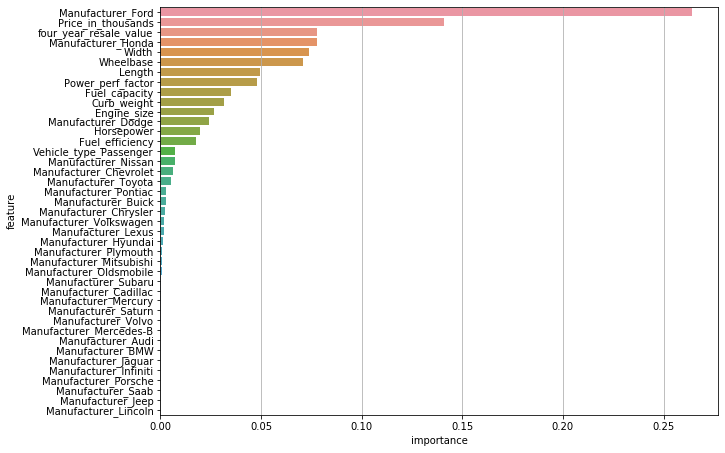

In [52]:
feature_rank = pd.DataFrame( columns = ['rank', 'feature', 'importance'] )
for f in range(train_X.shape[1]):
  feature_rank.loc[f] = [f+1,
                         train_X.columns[indices[f]],
                         clf_radm.feature_importances_[indices[f]]]
sns.barplot( y = 'feature', x = 'importance', data = feature_rank )